In [ ]:
!pip install datasets
!pip install transformers peft datasets accelerate bitsandbytes
!pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 17.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
import json
import gdown
from datasets import Dataset, load_dataset, concatenate_datasets
from transformers import Trainer, TrainingArguments, BertTokenizer, AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from peft import LoraConfig, get_peft_model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Initialize model 1 (to be fine-tuned without CL)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# we chose this small model
# model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-1M')
# model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama_v1.1")
# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama_v1.1")

# model_name = "meta-llama/Llama-2-7b"
model_name = "meta-llama/Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers import BitsAndBytesConfig

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config,
)

tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
# Configure LoRA
lora_config = LoraConfig(
    r=8,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Apply LoRA to specific transformer layers
    lora_dropout=0.1,  # Dropout for stability
    bias="none",  # Don't modify bias terms
    task_type="CAUSAL_LM"  # Task type for LLaMA 2
)

# Add LoRA adapters to the model
model = get_peft_model(model, lora_config)

# Check the number of trainable parameters
model.print_trainable_parameters()

trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


#Preprocessing OFFICIAL inputs before tokenizing

In [ ]:
def process_file(file_name):
      with open(file_name, 'r') as f:
        data = json.load(f)
      transformed_data = [{"text": item["question"], "label": item["answer"]} for item in data]

      # Convert the list of dictionaries into a HuggingFace Dataset object
      dataset = Dataset.from_dict({
          "text": [item["text"] for item in transformed_data],
          "label": [item["label"] for item in transformed_data]
      })
      return dataset

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=200,
        return_tensors="pt")

def shifting(examples):
    # examples['label'] = examples['input_ids'][1:]+[examples['label']]

    shifted_labels = []
    for input_ids, true_label in zip(examples['input_ids'], examples['label']):
        # Shift input_ids by removing the first token and adding the true label at the end
        shifted_label = input_ids[1:] + [true_label]
        shifted_labels.append(shifted_label)

    # Update the examples with the new shifted labels
    examples['labels'] = shifted_labels
    return examples


def preprocess(file_name):
    examples = process_file(file_name)
    columns_to_remove = [col for col in examples.column_names if col != 'label']

    tokenized_dataset = examples.map(
        tokenize_function,
        batched=True,
        remove_columns=columns_to_remove  # Remove the original columns except labels
    )
    print(type(tokenized_dataset['input_ids']))

    tokenized_dataset = tokenized_dataset.map(shifting, batched=True)

    tokenized_dataset.set_format("torch")
    return tokenized_dataset

In [ ]:
url = "https://drive.google.com/uc?id=1T6uUtzuo5bIyc4EI239UZacue8XR9v76"
file_id = "1T6uUtzuo5bIyc4EI239UZacue8XR9v76"
gdown.download(url, 'allsub_easy.json', quiet=False)

url = "https://drive.google.com/uc?id=1NabBNnhf5ZA8oVFvcRePJ1GsfSbcDUc_"
file_id = "1NabBNnhf5ZA8oVFvcRePJ1GsfSbcDUc_"
gdown.download(url, 'allsub_medium.json', quiet=False)

url = "https://drive.google.com/uc?id=1iQ1dSyywxRbwPhfpDJ7XNz80rVZLZRk-"
file_id = "1iQ1dSyywxRbwPhfpDJ7XNz80rVZLZRk"
gdown.download(url, 'allsub_hard.json', quiet=False)

url = "https://drive.google.com/uc?id=1L-YY03BVFWMWAynIdlX__LsKxgpc8w-y"
file_id = "1L-YY03BVFWMWAynIdlX__LsKxgpc8w-y"
gdown.download(url, 'allsub_test.json', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1T6uUtzuo5bIyc4EI239UZacue8XR9v76
To: /content/allsub_easy.json
100%|██████████| 111k/111k [00:00<00:00, 59.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NabBNnhf5ZA8oVFvcRePJ1GsfSbcDUc_
To: /content/allsub_medium.json
100%|██████████| 104k/104k [00:00<00:00, 66.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQ1dSyywxRbwPhfpDJ7XNz80rVZLZRk-
To: /content/allsub_hard.json
100%|██████████| 102k/102k [00:00<00:00, 61.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L-YY03BVFWMWAynIdlX__LsKxgpc8w-y
To: /content/allsub_test.json
100%|██████████| 105k/105k [00:00<00:00, 65.9MB/s]


'allsub_test.json'

In [ ]:
test_hard = preprocess("./allsub_test.json")
easy = preprocess("./allsub_easy.json")
medium = preprocess("./allsub_medium.json")
hard = preprocess("./allsub_hard.json")

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

##Preprocessing Subject Specific Data

In [ ]:
import zipfile
import os

In [ ]:
# Specify the path to the uploaded ZIP file
zip_file_path = '/content/train.zip'  # Replace with the correct filename

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/myfolder')  # Extracts to '/content/your_folder'

print("Folder extracted successfully!")

# Check the contents of the folder
print(os.listdir('/myfolder'))
print(os.listdir('/myfolder/train'))

Folder extracted successfully!
['__MACOSX', 'train']
['bio', 'phys', 'cs', '.DS_Store', 'math', 'chem']


In [ ]:
### Instructions: upload files first
subject = "math" #bio, chem, cs, math, phys

easy = preprocess(f"/myfolder/train/{subject}/easy.json")
medium = preprocess(f"/myfolder/train/{subject}/medium.json")
hard = preprocess(f"/myfolder/train/{subject}/hard.json")
test_hard = preprocess(f"/myfolder/train/{subject}/{subject}_test.json")

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

# Shuffled Model

In [ ]:
in_order_data = concatenate_datasets([easy, medium, hard]) # not relevant for shuffled model
shuffled_data = in_order_data.shuffle(seed=42)
# print(shuffled_data[0])

# Training args

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./lora_llama2_mmlu",
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=20,
    save_strategy="no",
    logging_strategy="epoch",     # Ensures logs are printed after every epoch
    logging_dir="./logs",
    logging_steps = 20,
    fp16=True,  # Use mixed precision for efficiency
    push_to_hub=False  # Set True if you want to save to Hugging Face Hub
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Evaluate non-fine-tuned model

In [ ]:
def process_file_new(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)

    # Handle both old and new JSON structures
    if isinstance(data, list):
        # Old format: list of dictionaries
        items = data
    else:
        # New format: dictionary with numbered keys
        items = [data[key] for key in data.keys()]

    transformed_data = [{"text": item["question"], "label": item["answer"]} for item in items]

    # Convert the list of dictionaries into a HuggingFace Dataset object
    dataset = Dataset.from_dict({
        "text": [item["text"] for item in transformed_data],
        "label": [item["label"] for item in transformed_data]
    })
    return dataset

def preprocess_new(file_name):
    examples = process_file_new(file_name)
    columns_to_remove = [col for col in examples.column_names if col != 'label']

    tokenized_dataset = examples.map(
        tokenize_function,
        batched=True,
        remove_columns=columns_to_remove  # Remove the original columns except labels
    )
    print(type(tokenized_dataset['input_ids']))

    tokenized_dataset = tokenized_dataset.map(shifting, batched=True)

    tokenized_dataset.set_format("torch")
    return tokenized_dataset

In [ ]:
pre_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_hard
)

results = pre_trainer.evaluate()
print(results)

iccl_val = preprocess_new(f"iccl_val.json")
results = pre_trainer.evaluate(eval_dataset=iccl_val)
print(results)

icl_random_val = preprocess_new(f"icl_random_val.json")
results = pre_trainer.evaluate(eval_dataset=icl_random_val)
print(results)

icl_all_hard_val = preprocess_new(f"icl_all_hard_val.json")
results = pre_trainer.evaluate(eval_dataset=icl_all_hard_val)
print(results)

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:452: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 11.066786766052246, 'eval_model_preparation_time': 0.0032, 'eval_runtime': 2.9518, 'eval_samples_per_second': 16.939, 'eval_steps_per_second': 4.404}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 10.258940696716309, 'eval_model_preparation_time': 0.0032, 'eval_runtime': 1.759, 'eval_samples_per_second': 28.426, 'eval_steps_per_second': 7.391}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 10.150019645690918, 'eval_model_preparation_time': 0.0032, 'eval_runtime': 1.7674, 'eval_samples_per_second': 28.29, 'eval_steps_per_second': 7.355}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 10.34332275390625, 'eval_model_preparation_time': 0.0032, 'eval_runtime': 1.7518, 'eval_samples_per_second': 28.541, 'eval_steps_per_second': 7.421}


# Shuffled

In [ ]:
# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    # train_dataset=train_data_shufflemodel,
    # eval_dataset=test_data_shufflemodel
    # train_dataset=concatenate_datasets([easy, medium, hard]).shuffle(seed=42),
    train_dataset=shuffled_data,
    eval_dataset=test_hard
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
0,10.810100,6.234340
1,4.074300,3.820477
2,3.230800,3.042534
4,2.588300,2.107427
5,1.794800,1.843356
6,1.587800,1.631066
8,1.616000,1.420597
9,1.222900,1.362533
10,1.173400,1.325210
12,1.395600,1.281757


TrainOutput(global_step=80, training_loss=2.2088307201862336, metrics={'train_runtime': 205.0885, 'train_samples_per_second': 14.628, 'train_steps_per_second': 0.39, 'total_flos': 8557910438707200.0, 'train_loss': 2.2088307201862336, 'epoch': 16.842105263157894})

In [ ]:
model.save_pretrained("./math_nocl")
# Evaluate on the test set
results = trainer.evaluate(eval_dataset=test_hard)
print(results)

{'eval_loss': 1.2516264915466309, 'eval_runtime': 1.8153, 'eval_samples_per_second': 27.544, 'eval_steps_per_second': 7.161, 'epoch': 16.842105263157894}


In [ ]:
results = trainer.evaluate()
print(results)

iccl_val = preprocess_new(f"iccl_val.json")
results = trainer.evaluate(eval_dataset=iccl_val)
print(results)

icl_random_val = preprocess_new(f"icl_random_val.json")
results = trainer.evaluate(eval_dataset=icl_random_val)
print(results)

icl_all_hard_val = preprocess_new(f"icl_all_hard_val.json")
results = trainer.evaluate(eval_dataset=icl_all_hard_val)
print(results)

{'eval_loss': 1.2516264915466309, 'eval_runtime': 1.8, 'eval_samples_per_second': 27.778, 'eval_steps_per_second': 7.222, 'epoch': 16.842105263157894}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 3.356247663497925, 'eval_runtime': 1.7708, 'eval_samples_per_second': 28.236, 'eval_steps_per_second': 7.341, 'epoch': 16.842105263157894}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 3.296492576599121, 'eval_runtime': 1.7811, 'eval_samples_per_second': 28.073, 'eval_steps_per_second': 7.299, 'epoch': 16.842105263157894}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 2.5978853702545166, 'eval_runtime': 1.782, 'eval_samples_per_second': 28.058, 'eval_steps_per_second': 7.295, 'epoch': 16.842105263157894}


## Let's plot!

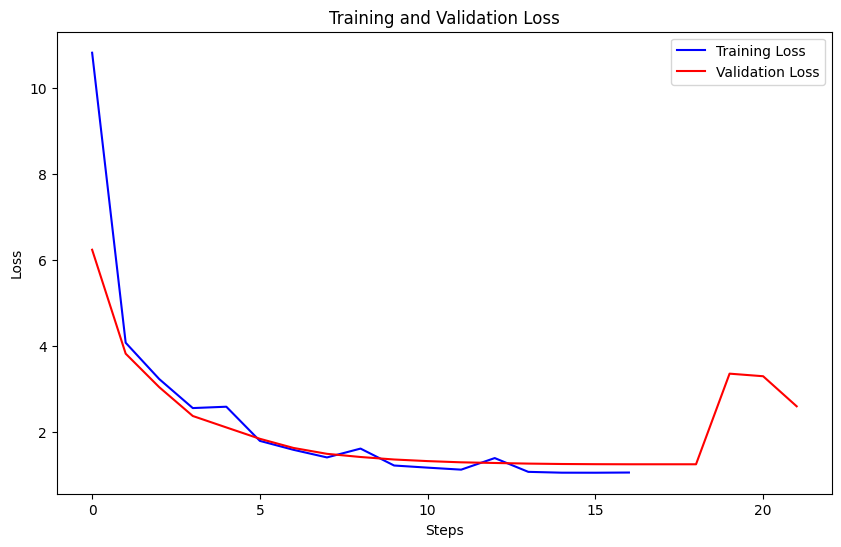

In [ ]:
import matplotlib.pyplot as plt

# Extract the log history from the trainer
log_history = trainer.state.log_history

# Lists to store training and validation losses
train_losses = []
eval_losses = []

# Loop through the log history and extract the relevant losses
for log in log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])  # Training loss
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])  # Validation loss

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Validation Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# CL

We wish to train our model in three stages, using easy, medium, and hard math questions.

In [ ]:
model_cl = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config,
)

# Add LoRA adapters to the model
model_cl = get_peft_model(model_cl, lora_config)

# Check the number of trainable parameters
model_cl.print_trainable_parameters()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


In [ ]:
# Create a function to train the model sequentially using Curriculum Learning
def train_curriculum_model(model, easy, medium, hard, test_data, training_args):
    # Split data into stages for Curriculum Learning: Easy -> Medium -> Hard
    stage_data = [easy, medium, hard]  # List of datasets in increasing difficulty

    for stage in range(len(stage_data)):
        # For each stage, train the model on the corresponding difficulty level
        current_stage_data = stage_data[stage]

        # Train the model on the current stage data
        cl_trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=current_stage_data,
            eval_dataset=test_data
        )

        print(f"Training on stage {stage + 1} (difficulty: {['easy', 'medium', 'hard'][stage]})")
        cl_trainer.train()

    return model


# Train the model on the curriculum data (easy -> medium -> hard)
trained_model = train_curriculum_model(model_cl, easy, medium, hard, test_hard, training_args)

# Evaluate the trained model on the test set (same for all stages)
eval_trainer = Trainer(
    model=trained_model,
    args=training_args,
    eval_dataset=test_hard
)
eval_trainer.evaluate()

Training on stage 1 (difficulty: easy)


Epoch,Training Loss,Validation Loss
0,22.498500,11.066787
1,22.508900,11.066787
2,19.587500,9.587349
3,7.750900,7.929832
4,13.659000,6.216407
5,9.492000,4.951947
6,8.532600,4.442312
7,3.913200,4.081128
8,6.721400,3.993586
9,7.275700,3.909725


Training on stage 2 (difficulty: medium)


Epoch,Training Loss,Validation Loss
0,5.886000,3.106905
1,5.853200,2.877335
2,5.255300,2.656888
3,2.308100,2.326852
4,4.268300,2.232961
5,4.103100,2.171970
6,3.972200,2.121260
7,1.796200,2.021244
8,3.156700,1.975826
9,3.475000,1.935606


Training on stage 3 (difficulty: hard)


Epoch,Training Loss,Validation Loss
0,3.456600,1.706614
1,3.157400,1.610208
2,3.008500,1.554630
3,1.627700,1.470298
4,2.871600,1.442146
5,3.016900,1.418536
6,2.801400,1.398197
7,1.353000,1.372454
8,2.601100,1.360787
9,2.563800,1.352096


{'eval_loss': 1.315799593925476,
 'eval_model_preparation_time': 0.0033,
 'eval_runtime': 1.7595,
 'eval_samples_per_second': 28.417,
 'eval_steps_per_second': 7.388}

In [ ]:
trained_model.save_pretrained("./math_cl")

In [ ]:
results = eval_trainer.evaluate()
print(results)

iccl_val = preprocess_new(f"iccl_val.json")
results = eval_trainer.evaluate(eval_dataset=iccl_val)
print(results)

icl_random_val = preprocess_new(f"icl_random_val.json")
results = eval_trainer.evaluate(eval_dataset=icl_random_val)
print(results)

icl_all_hard_val = preprocess_new(f"icl_all_hard_val.json")
results = eval_trainer.evaluate(eval_dataset=icl_all_hard_val)
print(results)

{'eval_loss': 1.315799593925476, 'eval_model_preparation_time': 0.0033, 'eval_runtime': 1.758, 'eval_samples_per_second': 28.442, 'eval_steps_per_second': 7.395}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 3.5830278396606445, 'eval_model_preparation_time': 0.0033, 'eval_runtime': 1.7732, 'eval_samples_per_second': 28.198, 'eval_steps_per_second': 7.331}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 3.5007238388061523, 'eval_model_preparation_time': 0.0033, 'eval_runtime': 1.7789, 'eval_samples_per_second': 28.108, 'eval_steps_per_second': 7.308}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 2.64593505859375, 'eval_model_preparation_time': 0.0033, 'eval_runtime': 1.7446, 'eval_samples_per_second': 28.659, 'eval_steps_per_second': 7.451}
